#  Imports

In [1]:
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preprocesado


In [3]:
def preprocess_image_tf(file_path, image_size=224):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size])
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    label = k
    image = tf.image.rot90(image, k=k)
    image = (image / 127.5) - 1.0
    return image, label


## Crear dataset

In [18]:
def create_rotnet_dataset(image_dir, image_size=224, batch_size=32):
    print(f"📁 Cargando imágenes desde: {image_dir}")

    image_paths = []
    for root, _, files in os.walk(image_dir):
        for fname in files:
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(root, fname))
    print(f"🔢 Total de imágenes encontradas: {len(image_paths)}")

    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image_tf, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    print(f"⏱️ Preprocesamiento completado.\n")

    return dataset


In [19]:
execution_path = os.getcwd()
print(f"El path de la ejecución es: {execution_path}")

El path de la ejecución es: e:\TFM\TFM\RotNet


In [20]:
# List the contents of the directory
contents = os.listdir(execution_path)
print(f"Contenido de '{execution_path}':")
print(contents)

Contenido de 'e:\TFM\TFM\RotNet':
['best_rotnet_model.keras', 'pocRotnet', 'preproces.py', 'preprocesFix.py', 'readme.md', 'rotnetPOC copy.ipynb', 'rotnetPOC.ipynb']


In [21]:
image_dir = "e:/TFM/DB/pocRotnet"
image_dir="e:/TFM/PlantsClassification/train"
# image_dir = os.path.join(execution_path,  "pocRotnet")
train = create_rotnet_dataset("e:/TFM/PlantsClassification/train")
val= create_rotnet_dataset("e:/TFM/PlantsClassification/test")

📁 Cargando imágenes desde: e:/TFM/PlantsClassification/train
🔢 Total de imágenes encontradas: 21000
⏱️ Preprocesamiento completado.

📁 Cargando imágenes desde: e:/TFM/PlantsClassification/test
🔢 Total de imágenes encontradas: 6000
⏱️ Preprocesamiento completado.



##  Definir modelo

In [22]:
def build_rotnet_model(input_shape=(224, 224, 3), num_classes=4):
    print("🔧 Construyendo un modelo mejorado para RotNet...")
    base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape, weights="imagenet")
    base_model.trainable = False  # Congelar las capas del modelo base

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ])
    print("✅ Modelo mejorado creado con éxito.\n")
    return model
model = build_rotnet_model()

model.summary()


🔧 Construyendo un modelo mejorado para RotNet...
✅ Modelo mejorado creado con éxito.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None

## Ejecutar entrenamiento

In [23]:
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print("🚀 Comenzando el entrenamiento...\n")


# history = model.fit(dataset, epochs=100, verbose=2)
history = model.fit(
    train,
    epochs=200,
    verbose=1,
    validation_data=val,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",  # Monitorear la pérdida en los datos de validación
            patience=10,  # Aumentar la paciencia para permitir más iteraciones
            restore_best_weights=True,  # Restaurar los mejores pesos al final
            min_delta=1e-4,  # Mínima mejora requerida para considerar un cambio significativo
            verbose=1  # Mostrar mensajes cuando se active el EarlyStopping
        ),
        tf.keras.callbacks.ModelCheckpoint(
            "best_rotnet_model.keras",
            monitor="val_loss",  # Guardar el mejor modelo basado en la pérdida de validación
            save_best_only=True,
            verbose=1
        )
    ]
)


print(f"\n✅ Entrenamiento finalizado.")

save_path = "E:/TFM/rotnet_model.keras"
model.save(save_path)
print(f"💾 Modelo guardado en: {save_path}")


🚀 Comenzando el entrenamiento...

Epoch 1/200
656/657 [============================>.] - ETA: 0s - loss: 1.4872 - accuracy: 0.3484
Epoch 1: val_loss improved from inf to 1.14558, saving model to best_rotnet_model.keras
657/657 [==============================] - 59s 83ms/step - loss: 1.4872 - accuracy: 0.3484 - val_loss: 1.1456 - val_accuracy: 0.4668
Epoch 2/200
655/657 [============================>.] - ETA: 0s - loss: 1.1779 - accuracy: 0.4543
Epoch 2: val_loss improved from 1.14558 to 1.08259, saving model to best_rotnet_model.keras
657/657 [==============================] - 41s 60ms/step - loss: 1.1777 - accuracy: 0.4544 - val_loss: 1.0826 - val_accuracy: 0.4958
Epoch 3/200
657/657 [==============================] - ETA: 0s - loss: 1.1349 - accuracy: 0.4737
Epoch 3: val_loss improved from 1.08259 to 1.06707, saving model to best_rotnet_model.keras
657/657 [==============================] - 48s 71ms/step - loss: 1.1349 - accuracy: 0.4737 - val_loss: 1.0671 - val_accuracy: 0.5022
Epoc

## Visualizar

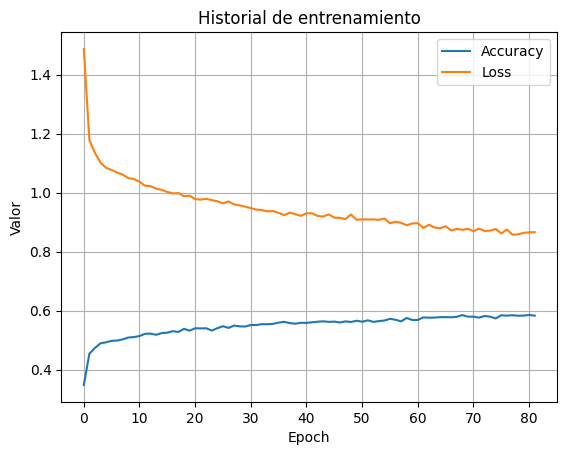

In [24]:
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["loss"], label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Valor")
plt.title("Historial de entrenamiento")
plt.legend()
plt.grid()
plt.show()


In [27]:
import pickle

history_path = "E:/TFM/history.pkl"
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

print(f"💾 Historial guardado en: {history_path}")


💾 Historial guardado en: E:/TFM/history.pkl
